# CNN + MaxPool
Fixed train/valid split.
Combine train+test in one. 
Put this in a loop of 10.
All, MCC.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-11 22:35:03.739408


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=12
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
CACHING = False   # have not worked out how to cache multiple cell lines
NUM_LINES = 15   # 15 to analyze all of them

Python 3.9.16
sklearn 1.2.1


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
SEQUENCE_TRAIN = 'train.all_lncRNA_transcripts.csv'
RCI_FILE_TEST  = 'test.lncRNA_RCI.csv'
SEQUENCE_TEST  = 'test.all_lncRNA_transcripts.csv'
CNN_FILE       = 'cnn_237.model'
GMM_FILE       = 'gmm_237.pickle'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS      = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = np.power(values,2)
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = 0.0
                        else:
                            log_mean = np.log2(big_mean) 
                        gene_to_rci[gene_id] = log_mean
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-11 22:35:10.886031
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                             

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False    
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def set_sequences(self, allids, allseq):
        # Keep IDs and sequences in same order.
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order.
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def _get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def _get_X_y(self, gene_index, exclude_middle=False):
        # gene_index is ndarray with subset of indices of all_genes
        subsetX=[]
        subsetY=[]
        gene_subset = self._get_gene_subset(gene_index)
        for t in range(len(self.all_ids)):
            gene_id,tran_id = self.all_ids[t]
            if gene_id in gene_subset:
                oneX            = self.all_seqs[t]
                oneY            = self.rci_map[gene_id]
                if exclude_middle and oneY >= -2 and oneY <= 0:
                    # Exclude middle from train set only, for comparison to Yuan et al
                    continue
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:
                # assume prior call to load_gmm()
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_without_validation(self):
        print(datetime.now())
        # for final train, the train subset is the entire data set
        train_index = range(len(self.all_ids))  
        X_train,y_rci = self._get_X_y(train_index) 
        self._prepare_threshold(y_rci,True)  # create and save
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        y_rci = None
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # validation_data=(X_valid,y_valid) ) 

        # for final train, there is no separate valid set
        X_valid = X_train   
        y_valid = y_train
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_valid, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        print('train class weights 1:0 %5.2f:%5.2f' % (cwd[1],cwd[0]))
        self._show_sizes('Train',y_valid)
        self._show_sizes('Predict',yhat_classes)
        print('Valid sizes',X_valid.shape,y_valid.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)

        accuracy = accuracy_score(y_valid, yhat_classes)*100.
        precision = precision_score(y_valid, yhat_classes)*100.
        recall = recall_score(y_valid, yhat_classes)*100.
        f1 = f1_score(y_valid, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_valid, yhat_pred)*100.
        mcc = matthews_corrcoef(y_valid, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_valid,yhat_pred,prc_X,prc_Y)
        print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
        print('F1: %.2f%% MCC: %.2f%%' % (f1,mcc)) 
        print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)
        
    def test_without_training(self):
        print(datetime.now())
        # for final train, the train subset is the entire data set
        train_index = range(len(self.all_ids))  
        X_train,y_rci = self._get_X_y(train_index) 
        self._prepare_threshold(y_rci,False)  # reload
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        y_rci = None
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}

        # for final test, do no train
        # assume load_cnn) has been called

        # for final test, there is no separate valid set
        X_valid = X_train   
        y_valid = y_train
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_valid, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        print('train class weights 1:0 %5.2f:%5.2f' % (cwd[1],cwd[0]))
        self._show_sizes('Train',y_valid)
        self._show_sizes('Predict',yhat_classes)
        print('Valid sizes',X_valid.shape,y_valid.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)

        accuracy = accuracy_score(y_valid, yhat_classes)*100.
        precision = precision_score(y_valid, yhat_classes)*100.
        recall = recall_score(y_valid, yhat_classes)*100.
        f1 = f1_score(y_valid, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_valid, yhat_pred)*100.
        mcc = matthews_corrcoef(y_valid, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_valid,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.2f%%' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def load_cnn(self,filename):
        self.model = keras.models.load_model(filename)
        
    def load_gmm(self,filename):
        gmm = pickle.load(open(filename,'rb'))
        self.discriminator = gmm
        
    def save_cnn(self,filename):
        self.model.save(filename)
        
    def save_gmm(self,filename):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            pickle.dump(gmm, open(filename,'wb'))
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

2023-03-11 22:35:11.109614
Loading...
2023-03-11 22:35:11.110145
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 19301 sequences.

Training # 0
2023-03-11 22:35:53.455519
2023-03-11 22:35:53.457594
Discriminator is GMM
Means [1.4363416352604474, -0.18563426001690153]
Variances [2.40467844 7.89863319]
Priors [0.731338 0.268662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-11 22:36:10.180199
Epoch 1/12
604/604 [==============================] - 10s 11ms/step - loss: 0.7011 - accuracy: 0.5095
Epoch 2/12
604/604 [==============================] - 6s 10ms/step - loss: 0.6657 - accuracy: 0.5945
Epoch 3/12
604/604 [==============================] - 7s 12ms/step - loss: 0.6016 - accuracy: 0.6671
Epoch 4/12
604/604 [==============================] - 6s 10ms/step - loss: 0.5222 - accuracy: 0.7392
Epoch 5/12
604/604 [==============================] - 7s 11ms/step - loss: 0.4328 - accuracy: 0.7951
Epoch 6/12
6

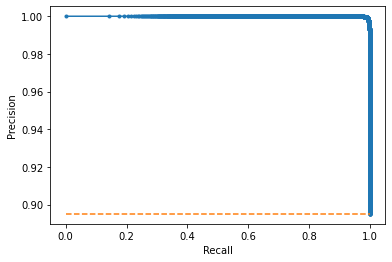

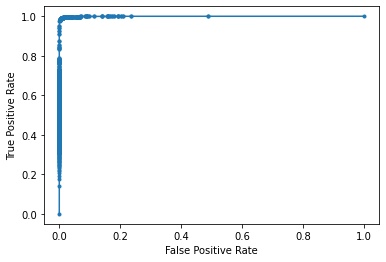

Accuracy: 98.75% Precision: 99.95% Recall: 98.65%
F1: 99.30% MCC: 0.94%
AUPRC: 99.99% AUROC: 99.96%



Loading...
2023-03-11 22:37:40.970539
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 6248 sequences.

Testing # 0
2023-03-11 22:37:49.572141
2023-03-11 22:37:50.203892
Discriminator is GMM
Means [1.4363416352604474, -0.18563426001690153]
Variances [2.40467844 7.89863319]
Priors [0.731338 0.268662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
PREDICT
2023-03-11 22:37:52.816755
train class weights 1:0  0.55: 5.79
Train 1:0 5708:540 91.36%
Predict 1:0 5518:730 88.32%
Valid sizes (6248, 4997) (6248,)
Range of scores: 1.1646379e-08 to 1.0
Score threshold 0.5


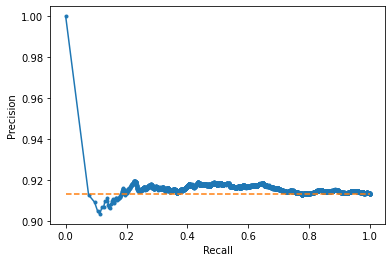

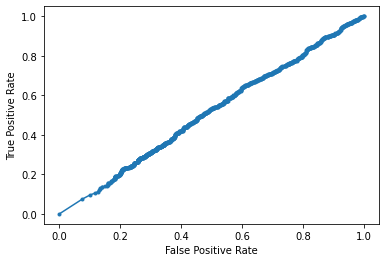

Accuracy: 82.04% Precision: 91.55% Recall: 88.51%
F1: 90.01% MCC: 0.02%
AUPRC: 91.83% AUROC: 51.21%
 accuracy [82.04225352112677]
 precision [91.55491119971005]
 recall [88.50735809390329]
 F1 [90.0053447354356]
 MCC [0.01934138032846807]
 AUPRC [91.83041697545558]
 AUROC [51.205228529159854]
Loading...
2023-03-11 22:37:54.782055
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 19301 sequences.

Training # 1
2023-03-11 22:38:25.403524
2023-03-11 22:38:25.405822
Discriminator is GMM
Means [1.4363416352604474, -0.18563426001690153]
Variances [2.40467844 7.89863319]
Priors [0.731338 0.268662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-11 22:38:43.154508
Epoch 1/12
604/604 [==============================] - 8s 11ms/step - loss: 0.7041 - accuracy: 0.5089
Epoch 2/12
604/604 [==============================] - 6s 10ms/step - loss: 0.6563 - accuracy: 0.6052
Epoch 3/12
604/604 [=============================

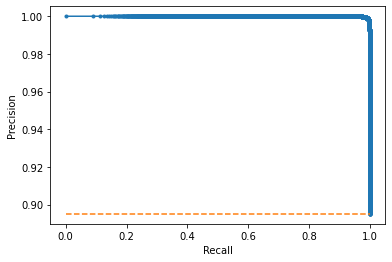

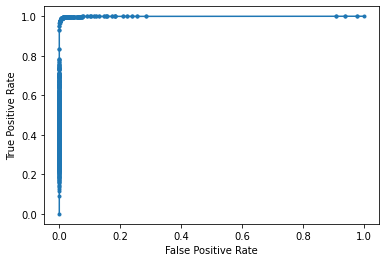

Accuracy: 97.91% Precision: 99.96% Recall: 97.70%
F1: 98.82% MCC: 0.90%
AUPRC: 99.99% AUROC: 99.94%



Loading...
2023-03-11 22:40:12.943576
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 6248 sequences.

Testing # 1
2023-03-11 22:40:23.681393
2023-03-11 22:40:24.485215
Discriminator is GMM
Means [1.4363416352604474, -0.18563426001690153]
Variances [2.40467844 7.89863319]
Priors [0.731338 0.268662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
PREDICT
2023-03-11 22:40:26.555892
train class weights 1:0  0.55: 5.79
Train 1:0 5708:540 91.36%
Predict 1:0 5278:970 84.48%
Valid sizes (6248, 4997) (6248,)
Range of scores: 3.3225928e-07 to 1.0
Score threshold 0.5


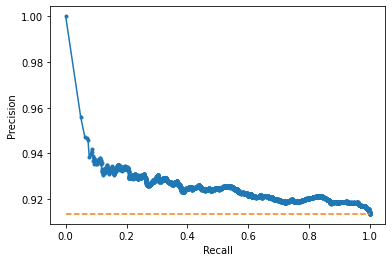

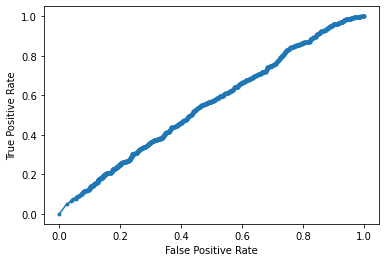

Accuracy: 79.67% Precision: 92.04% Recall: 85.11%
F1: 88.44% MCC: 0.06%
AUPRC: 92.77% AUROC: 55.30%
 accuracy [79.67349551856594]
 precision [92.04244031830238]
 recall [85.10861948142957]
 F1 [88.43983251410887]
 MCC [0.056881644513787626]
 AUPRC [92.77427977359672]
 AUROC [55.3002932855771]
Loading...
2023-03-11 22:40:29.857267
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 19301 sequences.

Training # 2
2023-03-11 22:41:00.707113
2023-03-11 22:41:00.710163
Discriminator is GMM
Means [1.4363416352604474, -0.18563426001690153]
Variances [2.40467844 7.89863319]
Priors [0.731338 0.268662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-11 22:41:15.503248
Epoch 1/12
604/604 [==============================] - 9s 12ms/step - loss: 0.7028 - accuracy: 0.5304
Epoch 2/12
604/604 [==============================] - 7s 11ms/step - loss: 0.6490 - accuracy: 0.6196
Epoch 3/12
604/604 [=============================

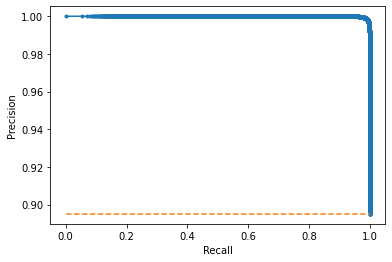

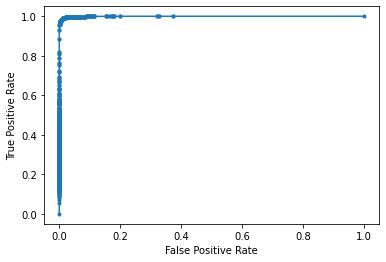

Accuracy: 93.00% Precision: 100.00% Recall: 92.18%
F1: 95.93% MCC: 0.74%
AUPRC: 99.99% AUROC: 99.94%



Loading...
2023-03-11 22:42:47.791040
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 6248 sequences.

Testing # 2
2023-03-11 22:42:59.391232
2023-03-11 22:42:59.986681
Discriminator is GMM
Means [1.4363416352604474, -0.18563426001690153]
Variances [2.40467844 7.89863319]
Priors [0.731338 0.268662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
PREDICT
2023-03-11 22:43:01.531365
train class weights 1:0  0.55: 5.79
Train 1:0 5708:540 91.36%
Predict 1:0 4657:1591 74.54%
Valid sizes (6248, 4997) (6248,)
Range of scores: 1.5330134e-10 to 1.0
Score threshold 0.5


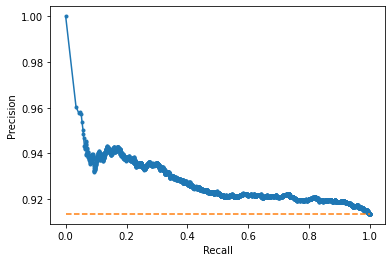

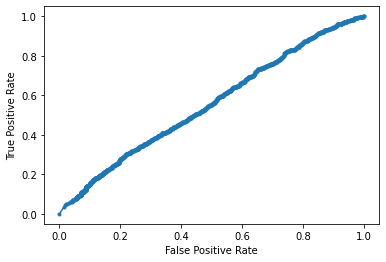

Accuracy: 71.33% Precision: 92.05% Recall: 75.11%
F1: 82.72% MCC: 0.04%
AUPRC: 92.88% AUROC: 55.56%
 accuracy [71.3348271446863]
 precision [92.05497101138072]
 recall [75.10511562718992]
 F1 [82.7206946454414]
 MCC [0.042482664966530324]
 AUPRC [92.87663716311206]
 AUROC [55.563828544732544]
Loading...
2023-03-11 22:43:03.547148
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 19301 sequences.

Training # 3
2023-03-11 22:43:34.064289
2023-03-11 22:43:34.067563
Discriminator is GMM
Means [1.4363416352604474, -0.18563426001690153]
Variances [2.40467844 7.89863319]
Priors [0.731338 0.268662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-11 22:43:50.545777
Epoch 1/12
604/604 [==============================] - 8s 11ms/step - loss: 0.7004 - accuracy: 0.5164
Epoch 2/12
604/604 [==============================] - 7s 11ms/step - loss: 0.6577 - accuracy: 0.6102
Epoch 3/12
604/604 [=============================

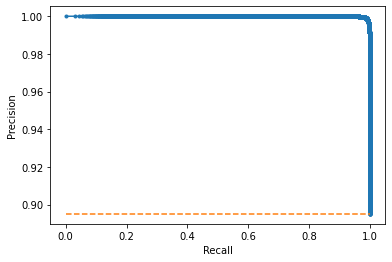

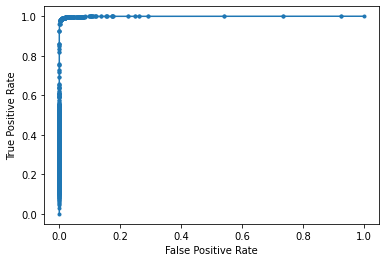

Accuracy: 95.25% Precision: 99.99% Recall: 94.70%
F1: 97.28% MCC: 0.81%
AUPRC: 99.99% AUROC: 99.93%



Loading...
2023-03-11 22:45:22.316433
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 6248 sequences.

Testing # 3
2023-03-11 22:45:31.848978
2023-03-11 22:45:32.459474
Discriminator is GMM
Means [1.4363416352604474, -0.18563426001690153]
Variances [2.40467844 7.89863319]
Priors [0.731338 0.268662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
PREDICT
2023-03-11 22:45:34.684988
train class weights 1:0  0.55: 5.79
Train 1:0 5708:540 91.36%
Predict 1:0 4866:1382 77.88%
Valid sizes (6248, 4997) (6248,)
Range of scores: 3.1412252e-08 to 1.0
Score threshold 0.5


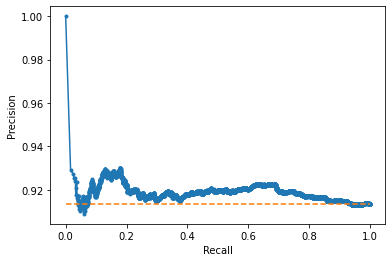

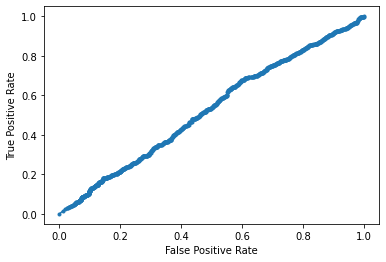

Accuracy: 73.62% Precision: 91.72% Recall: 78.19%
F1: 84.41% MCC: 0.02%
AUPRC: 91.95% AUROC: 52.68%
 accuracy [73.6235595390525]
 precision [91.718043567612]
 recall [78.1885073580939]
 F1 [84.41460185360317]
 MCC [0.024094163640782824]
 AUPRC [91.95363813026337]
 AUROC [52.67681486672377]
Loading...
2023-03-11 22:45:36.688258
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 19301 sequences.

Training # 4
2023-03-11 22:46:04.368238
2023-03-11 22:46:04.373079
Discriminator is GMM
Means [1.4363416352604474, -0.18563426001690153]
Variances [2.40467844 7.89863319]
Priors [0.731338 0.268662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-11 22:46:20.764469
Epoch 1/12
604/604 [==============================] - 9s 11ms/step - loss: 0.6954 - accuracy: 0.5440
Epoch 2/12
604/604 [==============================] - 7s 12ms/step - loss: 0.6410 - accuracy: 0.6249
Epoch 3/12
604/604 [==============================] 

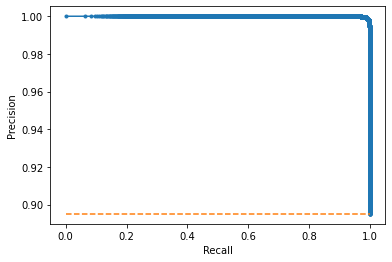

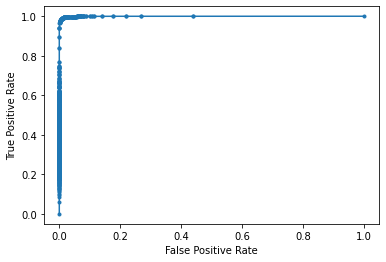

Accuracy: 96.48% Precision: 99.99% Recall: 96.07%
F1: 97.99% MCC: 0.85%
AUPRC: 100.00% AUROC: 99.96%



Loading...
2023-03-11 22:48:53.615463
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 6248 sequences.

Testing # 4
2023-03-11 22:49:02.577368
2023-03-11 22:49:03.412673
Discriminator is GMM
Means [1.4363416352604474, -0.18563426001690153]
Variances [2.40467844 7.89863319]
Priors [0.731338 0.268662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
PREDICT
2023-03-11 22:49:05.116182
train class weights 1:0  0.55: 5.79
Train 1:0 5708:540 91.36%
Predict 1:0 5001:1247 80.04%
Valid sizes (6248, 4997) (6248,)
Range of scores: 1.9175538e-08 to 1.0
Score threshold 0.5


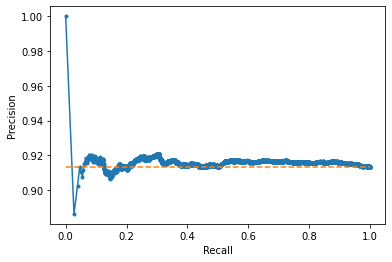

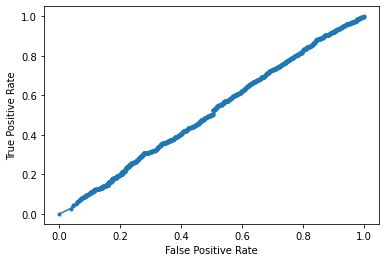

Accuracy: 75.21% Precision: 91.58% Recall: 80.24%
F1: 85.54% MCC: 0.02%
AUPRC: 91.61% AUROC: 51.34%
 accuracy [75.20806658130603]
 precision [91.58168366326734]
 recall [80.23826208829713]
 F1 [85.53553086189186]
 MCC [0.015996158840438243]
 AUPRC [91.61016027120066]
 AUROC [51.343825430195444]
Loading...
2023-03-11 22:49:07.185510
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 19301 sequences.

Training # 5
2023-03-11 22:49:37.771888
2023-03-11 22:49:37.774826
Discriminator is GMM
Means [1.4363416352604474, -0.18563426001690153]
Variances [2.40467844 7.89863319]
Priors [0.731338 0.268662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-11 22:49:54.659332
Epoch 1/12
604/604 [==============================] - 8s 12ms/step - loss: 0.7007 - accuracy: 0.5198
Epoch 2/12
604/604 [==============================] - 7s 11ms/step - loss: 0.6361 - accuracy: 0.6213
Epoch 3/12
604/604 [===========================

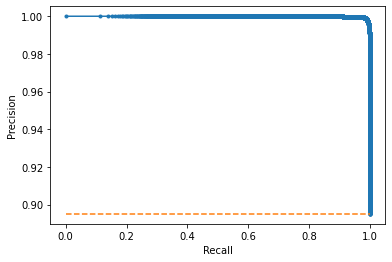

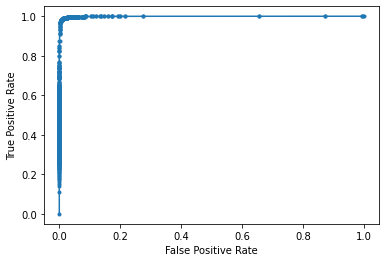

Accuracy: 97.58% Precision: 99.95% Recall: 97.35%
F1: 98.63% MCC: 0.89%
AUPRC: 99.99% AUROC: 99.91%



Loading...
2023-03-11 22:51:26.446052
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 6248 sequences.

Testing # 5
2023-03-11 22:51:34.226221
2023-03-11 22:51:35.676789
Discriminator is GMM
Means [1.4363416352604474, -0.18563426001690153]
Variances [2.40467844 7.89863319]
Priors [0.731338 0.268662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
PREDICT
2023-03-11 22:51:38.148820
train class weights 1:0  0.55: 5.79
Train 1:0 5708:540 91.36%
Predict 1:0 5209:1039 83.37%
Valid sizes (6248, 4997) (6248,)
Range of scores: 4.080949e-06 to 1.0
Score threshold 0.5


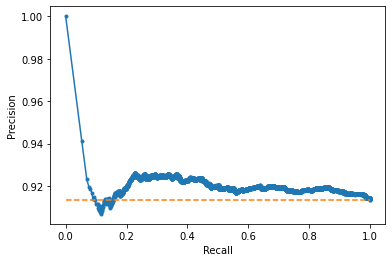

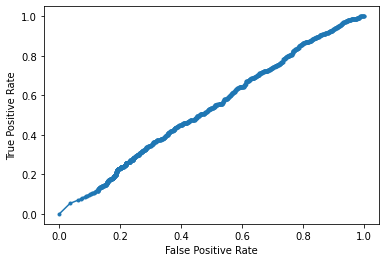

Accuracy: 78.44% Precision: 91.86% Recall: 83.83%
F1: 87.66% MCC: 0.04%
AUPRC: 92.22% AUROC: 53.41%
 accuracy [78.44110115236876]
 precision [91.8602418890382]
 recall [83.82971268395235]
 F1 [87.66144545204727]
 MCC [0.04008169585093095]
 AUPRC [92.22039737386015]
 AUROC [53.4119916167043]
Loading...
2023-03-11 22:51:40.204820
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 19301 sequences.

Training # 6
2023-03-11 22:52:10.699928
2023-03-11 22:52:10.703027
Discriminator is GMM
Means [1.4363416352604474, -0.18563426001690153]
Variances [2.40467844 7.89863319]
Priors [0.731338 0.268662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-11 22:52:28.497220
Epoch 1/12
604/604 [==============================] - 9s 11ms/step - loss: 0.6989 - accuracy: 0.5210
Epoch 2/12
604/604 [==============================] - 7s 11ms/step - loss: 0.6443 - accuracy: 0.6279
Epoch 3/12
604/604 [==============================]

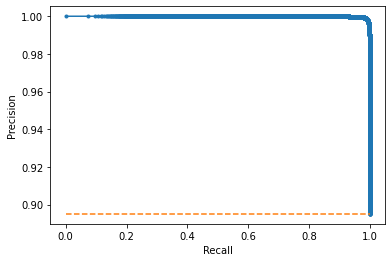

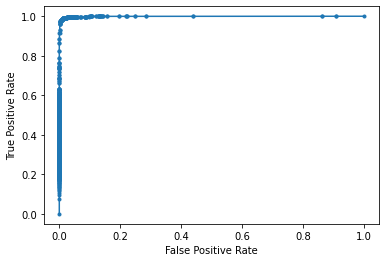

Accuracy: 95.37% Precision: 99.98% Recall: 94.85%
F1: 97.35% MCC: 0.81%
AUPRC: 99.99% AUROC: 99.92%



Loading...
2023-03-11 22:54:00.410409
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 6248 sequences.

Testing # 6
2023-03-11 22:54:08.200384
2023-03-11 22:54:08.990065
Discriminator is GMM
Means [1.4363416352604474, -0.18563426001690153]
Variances [2.40467844 7.89863319]
Priors [0.731338 0.268662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
PREDICT
2023-03-11 22:54:11.801180
train class weights 1:0  0.55: 5.79
Train 1:0 5708:540 91.36%
Predict 1:0 4946:1302 79.16%
Valid sizes (6248, 4997) (6248,)
Range of scores: 3.6789365e-06 to 1.0
Score threshold 0.5


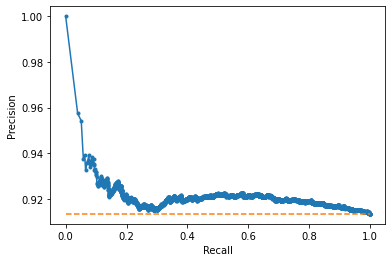

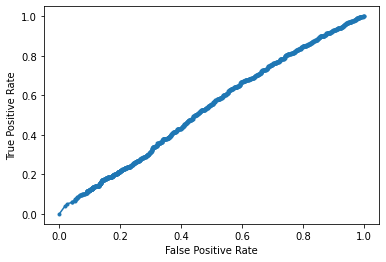

Accuracy: 75.00% Precision: 91.91% Recall: 79.64%
F1: 85.34% MCC: 0.04%
AUPRC: 92.33% AUROC: 53.51%
 accuracy [75.0]
 precision [91.91265669227658]
 recall [79.6426068675543]
 F1 [85.33883987234843]
 MCC [0.03852539458967008]
 AUPRC [92.3333474179322]
 AUROC [53.507195878429236]
Loading...
2023-03-11 22:54:13.454506
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 19301 sequences.

Training # 7
2023-03-11 22:54:43.959999
2023-03-11 22:54:43.963567
Discriminator is GMM
Means [1.4363416352604474, -0.18563426001690153]
Variances [2.40467844 7.89863319]
Priors [0.731338 0.268662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-11 22:55:00.873330
Epoch 1/12
604/604 [==============================] - 9s 11ms/step - loss: 0.7013 - accuracy: 0.5506
Epoch 2/12
604/604 [==============================] - 7s 11ms/step - loss: 0.6386 - accuracy: 0.6308
Epoch 3/12
604/604 [==============================] - 7s 11ms/s

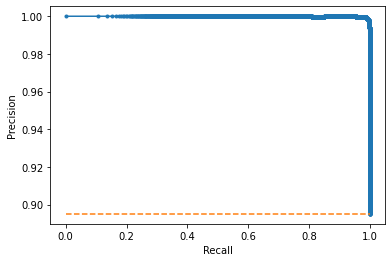

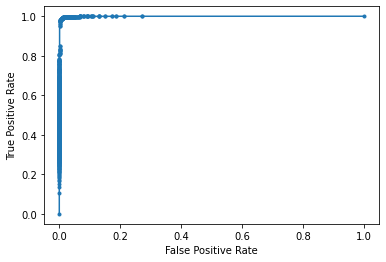

Accuracy: 98.35% Precision: 99.95% Recall: 98.21%
F1: 99.07% MCC: 0.92%
AUPRC: 99.99% AUROC: 99.94%



Loading...
2023-03-11 22:56:30.737156
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 6248 sequences.

Testing # 7
2023-03-11 22:56:40.695187
2023-03-11 22:56:41.297871
Discriminator is GMM
Means [1.4363416352604474, -0.18563426001690153]
Variances [2.40467844 7.89863319]
Priors [0.731338 0.268662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
PREDICT
2023-03-11 22:56:42.826499
train class weights 1:0  0.55: 5.79
Train 1:0 5708:540 91.36%
Predict 1:0 5465:783 87.47%
Valid sizes (6248, 4997) (6248,)
Range of scores: 1.4827947e-07 to 1.0
Score threshold 0.5


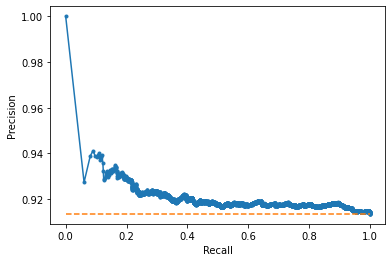

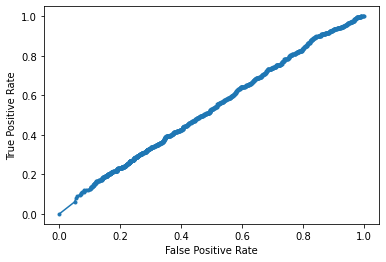

Accuracy: 81.80% Precision: 91.82% Recall: 87.91%
F1: 89.82% MCC: 0.04%
AUPRC: 92.36% AUROC: 53.08%
 accuracy [81.8021766965429]
 precision [91.82067703568161]
 recall [87.91170287316048]
 F1 [89.8236820907545]
 MCC [0.04357249471839861]
 AUPRC [92.35931811444792]
 AUROC [53.08204534246931]
Loading...
2023-03-11 22:56:44.964558
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 19301 sequences.

Training # 8
2023-03-11 22:57:15.447731
2023-03-11 22:57:15.450976
Discriminator is GMM
Means [1.4363416352604474, -0.18563426001690153]
Variances [2.40467844 7.89863319]
Priors [0.731338 0.268662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-11 22:57:40.742853
Epoch 1/12
604/604 [==============================] - 8s 11ms/step - loss: 0.7040 - accuracy: 0.5271
Epoch 2/12
604/604 [==============================] - 7s 11ms/step - loss: 0.6567 - accuracy: 0.5992
Epoch 3/12
604/604 [==============================]

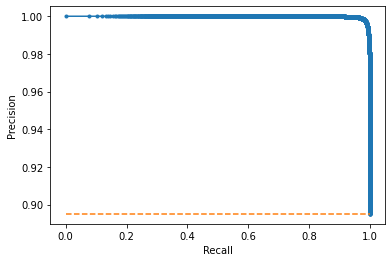

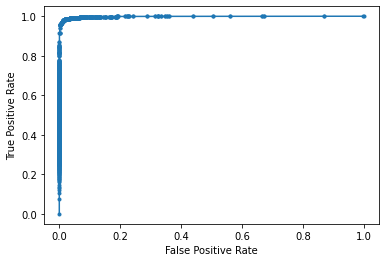

Accuracy: 98.39% Precision: 99.74% Recall: 98.47%
F1: 99.10% MCC: 0.92%
AUPRC: 99.98% AUROC: 99.83%



Loading...
2023-03-11 23:00:12.229432
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 6248 sequences.

Testing # 8
2023-03-11 23:00:20.400381
2023-03-11 23:00:21.261983
Discriminator is GMM
Means [1.4363416352604474, -0.18563426001690153]
Variances [2.40467844 7.89863319]
Priors [0.731338 0.268662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
PREDICT
2023-03-11 23:00:24.030784
train class weights 1:0  0.55: 5.79
Train 1:0 5708:540 91.36%
Predict 1:0 5480:768 87.71%
Valid sizes (6248, 4997) (6248,)
Range of scores: 3.5843792e-10 to 1.0
Score threshold 0.5


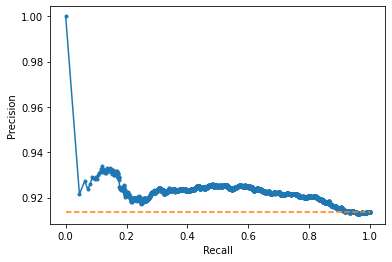

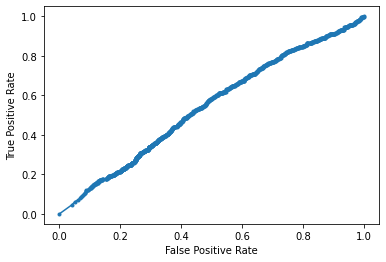

Accuracy: 81.63% Precision: 91.61% Recall: 87.95%
F1: 89.74% MCC: 0.02%
AUPRC: 92.39% AUROC: 54.34%
 accuracy [81.62612035851473]
 precision [91.6058394160584]
 recall [87.94674141555711]
 F1 [89.73900607794066]
 MCC [0.023633163719050637]
 AUPRC [92.39451262427683]
 AUROC [54.34382218588596]
Loading...
2023-03-11 23:00:25.747587
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 19301 sequences.

Training # 9
2023-03-11 23:00:55.858585
2023-03-11 23:00:55.862070
Discriminator is GMM
Means [1.4363416352604474, -0.18563426001690153]
Variances [2.40467844 7.89863319]
Priors [0.731338 0.268662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-11 23:01:11.202194
Epoch 1/12
604/604 [==============================] - 9s 12ms/step - loss: 0.6973 - accuracy: 0.5270
Epoch 2/12
604/604 [==============================] - 7s 11ms/step - loss: 0.6475 - accuracy: 0.6176
Epoch 3/12
604/604 [=============================

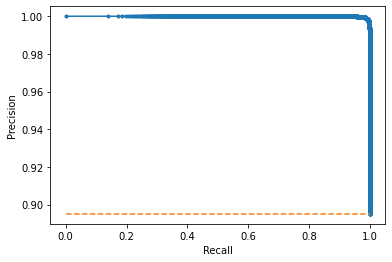

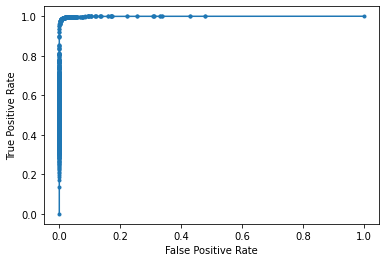

Accuracy: 98.72% Precision: 99.88% Recall: 98.69%
F1: 99.28% MCC: 0.94%
AUPRC: 99.99% AUROC: 99.94%



Loading...
2023-03-11 23:02:41.515715
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 6248 sequences.

Testing # 9
2023-03-11 23:02:52.937332
2023-03-11 23:02:54.008188
Discriminator is GMM
Means [1.4363416352604474, -0.18563426001690153]
Variances [2.40467844 7.89863319]
Priors [0.731338 0.268662]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
PREDICT
2023-03-11 23:02:55.567596
train class weights 1:0  0.55: 5.79
Train 1:0 5708:540 91.36%
Predict 1:0 5425:823 86.83%
Valid sizes (6248, 4997) (6248,)
Range of scores: 7.897702e-08 to 1.0
Score threshold 0.5


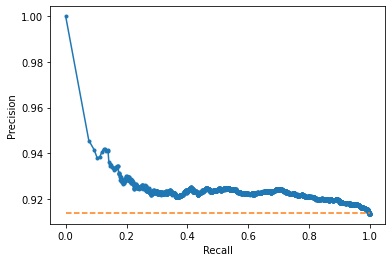

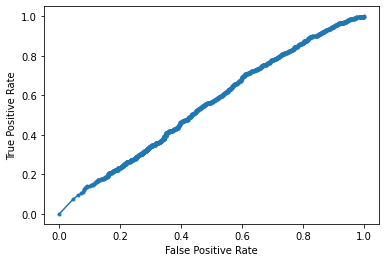

Accuracy: 81.48% Precision: 91.94% Recall: 87.39%
F1: 89.61% MCC: 0.05%
AUPRC: 92.77% AUROC: 55.22%
 accuracy [81.4820742637644]
 precision [91.9447004608295]
 recall [87.38612473721093]
 F1 [89.60747327764305]
 MCC [0.053676594805926944]
 AUPRC [92.77345428213023]
 AUROC [55.219720859612245]
2023-03-11 23:02:57.270707


In [10]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

for repeats in range(10):
    print("Loading...")
    print(datetime.now())
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TRAIN
    gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(gene_to_rci.keys()))
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_TRAIN
    allids,allseq = loader.load_sequence(filepath)
    print('Loaded',len(allseq),'sequences.')
    loader = None  # drop K-mer cache to save RAM
    print()
    print("Training #",repeats)
    print(datetime.now())
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cvdo.set_sequences(allids,allseq)
    cvdo.set_rci_map(gene_to_rci)
    cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
    cvdo.train_without_validation()
    filepath = DATA_DIR+GMM_FILE
    cvdo.save_gmm(filepath)
    filepath = DATA_DIR+CNN_FILE
    cvdo.save_cnn(filepath)

    print()
    print("Loading...")
    print(datetime.now())
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(gene_to_rci.keys()))
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_TEST
    allids,allseq = loader.load_sequence(filepath)
    print('Loaded',len(allseq),'sequences.')
    loader = None  # drop K-mer cache to save RAM

    print()
    print("Testing #",repeats)
    print(datetime.now())
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cvdo.set_sequences(allids,allseq)
    cvdo.set_rci_map(gene_to_rci)
    cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
    filepath = DATA_DIR+GMM_FILE
    cvdo.load_gmm(filepath)
    filepath = DATA_DIR+CNN_FILE
    cvdo.load_cnn(filepath)
    cvdo.test_without_training()
    cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
        cvdo.get_statistics()

    print(" accuracy" ,  cv_accuracy)
    print(" precision" , cv_precision)
    print(" recall" ,    cv_recall)
    print(" F1" ,        cv_f1)
    print(" MCC" ,       cv_mcc)
    print(" AUPRC" ,     cv_auprc)
    print(" AUROC" ,     cv_auroc)

    accuracy.append(cv_accuracy)
    precision.append(cv_precision)
    recall.append(cv_recall)
    f1.append(cv_f1)
    mcc.append(cv_mcc)
    auprc.append(cv_auprc)
    auroc.append(cv_auroc)
print(datetime.now())

In [11]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 78.02% std 3.94
 precision mean 91.81% std 0.19
 recall mean 83.39% std 4.79
 F1 mean 87.33% std 2.64
 MCC mean 0.04% std 0.01
 AUPRC mean 92.31% std 0.42
 AUROC mean 53.57% std 1.56
 accuracy [[82.04225352112677], [79.67349551856594], [71.3348271446863], [73.6235595390525], [75.20806658130603], [78.44110115236876], [75.0], [81.8021766965429], [81.62612035851473], [81.4820742637644]]
 precision [[91.55491119971005], [92.04244031830238], [92.05497101138072], [91.718043567612], [91.58168366326734], [91.8602418890382], [91.91265669227658], [91.82067703568161], [91.6058394160584], [91.9447004608295]]
 recall [[88.50735809390329], [85.10861948142957], [75.10511562718992], [78.1885073580939], [80.23826208829713], [83.82971268395235], [79.6426068675543], [87.91170287316048], [87.94674141555711], [87.38612473721093]]
 F1 [[90.0053447354356], [88.43983251410887], [82.7206946454414], [84.41460185360317], [85.53553086189186], [87.66144545204727], [85.33883987234843], [89.8236820907